# 00 trefor park

In [1]:
import torch
from torch.utils.data import DataLoader
from core.util.plot_predictions import plot_every_model
from core.util.save_model import load_model, load_parameters
from core.util.get_datasets import cross_validation
from core.util.trefor_dataset import TreforData
from core.models import LSTM, GRU, CNNLSTM
from core.models.model_training import test_model
from core.util.hyperparameter_configuration import get_hyperparameter_configuration

## Configuration
Parameters specific to this experiment

If the host has CUDA, it will use the GPU for computation

In [2]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
device

'cpu'

## Change these
Specify the features for this experiment, the best models and the experiment number.

In [3]:
features = {}
best_model_num = {
    "LSTM": 2,
    "GRU": 0,
    "CNN_LSTM": 2,
}
experiment_no = 0

In [4]:
params = {
    k: load_parameters(f"{experiment_no:02}_{k}_trefor_park_{v}")
    for k, v in best_model_num.items()
}

best_models = {
    "LSTM": load_model(LSTM, f"{experiment_no:02}_LSTM_trefor_park", device),
    "GRU": load_model(GRU, f"{experiment_no:02}_GRU_trefor_park", device),
    "CNN_LSTM": load_model(CNNLSTM, f"{experiment_no:02}_CNN_LSTM_trefor_park", device),
}

Global hyperparameter configuration

In [5]:
hyperparameters = get_hyperparameter_configuration()
loss_function = hyperparameters["loss_function"]
horizon = hyperparameters["horizon"]
train_days = hyperparameters["train_days"]
val_days = hyperparameters["val_days"]
test_days = hyperparameters["test_days"]
lookback = 96

### Main loop
Iterate all hyperparameter configuration to find the best one.

For each of these, we do the full iteration of epochs (unless early stop occurs) with training and validation.
Lastly, we run the test set on the given model to see how it performs using the metrics MAE, RMSE, and sMAPE.

In [6]:
_, _, _, _, x_test, y_test = cross_validation(
    lookback=lookback,
    horizon=horizon,
    train_days=train_days,
    val_days=val_days,
    test_days=test_days,
    features=features,
)

results = {}

# test each model
for name, model in best_models.items():
    lb = params[name]["lookback"]
    lookback_specific_x = x_test[:, -lb:, :]
    test_dataset = TreforData(lookback_specific_x, y_test, device)

    testing_loader = DataLoader(
        test_dataset, batch_size=params[name]["batch_size"], shuffle=False
    )
    _, predicted = test_model(
        best_model=model,
        loss_function=loss_function,
        testing_loader=testing_loader,
    )
    results[name] = predicted

In order to select the second best model we sort the results by lowest sMAPE.

sMAPE is the chosen metric as the loss is lower when predictions are larger than the actual value compared to when predictions are lower than the actual value.
$$\hat{y} > y: \text{lower loss} \\ \hat{y} < y: \text{greater loss}$$

## Plotting

### Predictions- and actual consumption

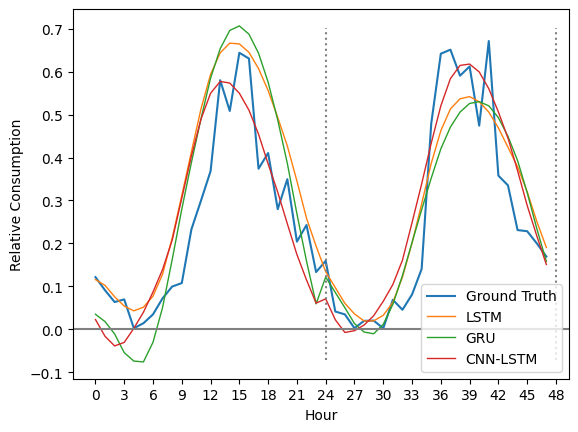

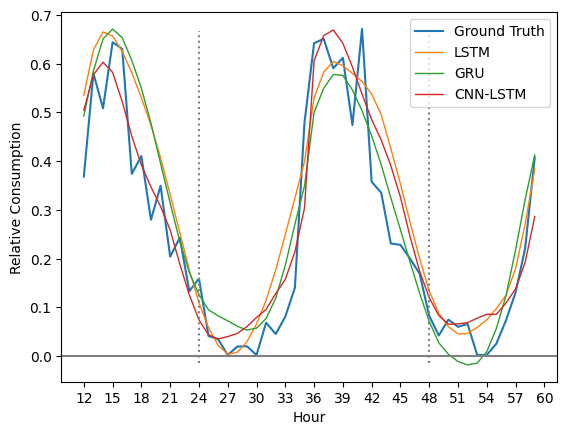

In [7]:
plot_every_model(200, 202, y_test, *results.values(), f"{experiment_no:02}.svg")

plot_every_model(
    200, 202, y_test, *results.values(), f"{experiment_no:02}_12-offset.svg", 12
)